# TUTORIAL: MLflow integration in AI Notebooks

*The purpose of this tutorial is to show how it is possible to use MLflow with AI Notebooks.*

## Introduction

In this tutorial, you will be able to run **MLflow** inside your notebook for basic model tracking.

In this context, several EfficientNet models will be trained on the same dataset (`stanford_dogs`). They will be tracked thanks to MLflow in order to be compare.

**What is MLflow?**

MLflow is an open-source platform for Machine Learning workflows management. You can use this tool for ML model **tracking**, **versionning** but also **storage** and **deployment**.

**How to use MLflow inside AI Notebooks?**

![](./assets/mlflow-inside-notebook.png)

## Definitions

### Transfer Learning

For both humans and machines, learning something new takes time and practice. However, it is easier to perform similar tasks to those already learned.
As with humans, AI will be able to identify patterns from previous knowledge and apply them to new learning.

If a model is trained on a database, there is no need to re-train the model from scratch to fit a new set of similar data. 

Main advantages of **Transfer Learning**:
- saving resources 
- improving efficiency 
- model training facilitation
- saving time

### EfficientNet

[EfficientNet](https://paperswithcode.com/method/efficientnet) models are convolutional neural networks based on a concept known as **compound scaling**. This concept enables a compromise to be found between model size, accuracy and computational efficiency. The idea behind compound scaling is to scale three essential dimensions of a neural network: width, depth and resolution.

In this tutorial, the following EfficientNet models will be compared: 

- EfficientNet-b0
- EfficientNet-b1
- EfficientNet-b2
- EfficientNet-b3
- EfficientNet-b4
- EfficientNet-b5
- EfficientNet-b6
- EfficientNet-b7

## Dataset

To show how Transfer Learning can be useful, and to compare these models, the trainings will be done on a custom dataset. 

#### **USE CASE:** Stanford Dogs dataset

The Stanford Dogs dataset contains images of **120 breeds** of dogs from around the world.

This dataset has been split in two for *training* and *validation*.

## Code

To train EfficientNet models on custom dataset and track them with MLflow, you have to follow the next steps.

### Step 1 - Librairies installation and import

First of all, install `mlflow` for model tracking and `tensorflow_datasets` for data loading.

In [ ]:
!pip install mlflow[extras] mlflow tensorflow_datasets

Then, disable `INFO` and `WARNING` messages from TensorFlow logs.

In [1]:
# set up tensorflow debug level
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

Now, you can import the needed dependencies.

In [2]:
# import dependencies
import matplotlib.pyplot as plt
import mlflow.tensorflow
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import applications, layers, models

### Step 2 - Load the dataset

In this step, you can load the `stanford_dogs` dataset and define the `batch_size`.

The aim is also to retrieve information on the various classes `nmb_classes`.

In [3]:
# define batch size
batch_size = 64

# load dataset
dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)

# define the number of classes
nmb_classes = ds_info.features["label"].num_classes

### Step 3 - Choose the model to train

You can train the following **EfficientNet** models:
- EfficientNet-b0
- EfficientNet-b1
- EfficientNet-b2
- EfficientNet-b3
- EfficientNet-b4
- EfficientNet-b5
- EfficientNet-b6
- EfficientNet-b7

In [4]:
# choose efficientnet model (e.g. "EfficientNet-b0")
my_model = "EfficientNet-b7"

### Step 4 - Set image size according to model

Here, you can define image size according to the targeted model.

In [5]:
# set up image size
image_sizes = {
    "EfficientNet-b0": 224,
    "EfficientNet-b1": 240,
    "EfficientNet-b2": 260,
    "EfficientNet-b3": 300,
    "EfficientNet-b4": 380,
    "EfficientNet-b5": 456,
    "EfficientNet-b6": 528,
    "EfficientNet-b7": 600,
}

In [6]:
IMG_SIZE = image_sizes[my_model]

size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

### Step 5 - Data processing on labels

Appy 

In [7]:
# format the labels
def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]

# one-hot/categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, nmb_classes)
    return image, label

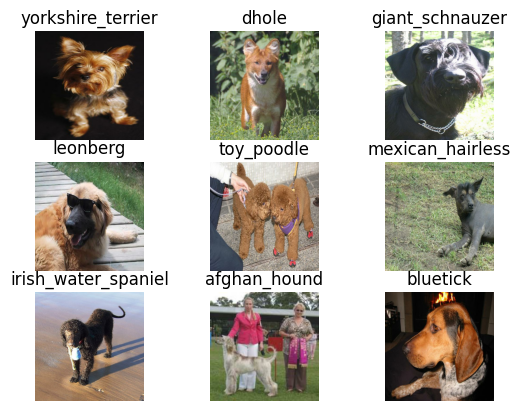

In [8]:
label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")

### Step 5 - Apply data augmentation on images

In [9]:
img_augmentation = models.Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

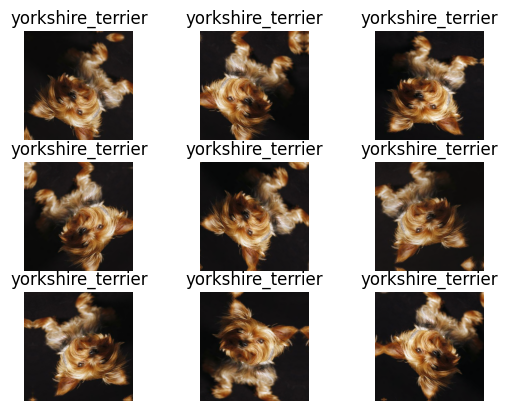

In [10]:
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")

In [11]:
# train set
ds_train = ds_train.map(input_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [12]:
# test set
ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)

### Step 6 -  Define the model architecture

In [13]:
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = img_augmentation(inputs)

In [14]:
# define EfficientNet models
efficientnet_models = {
       "EfficientNet-b0": applications.EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet"),
       "EfficientNet-b1": applications.EfficientNetB1(include_top=False, input_tensor=x, weights="imagenet"),
       "EfficientNet-b2": applications.EfficientNetB2(include_top=False, input_tensor=x, weights="imagenet"),
       "EfficientNet-b3": applications.EfficientNetB3(include_top=False, input_tensor=x, weights="imagenet"),
       "EfficientNet-b4": applications.EfficientNetB4(include_top=False, input_tensor=x, weights="imagenet"),
       "EfficientNet-b5": applications.EfficientNetB5(include_top=False, input_tensor=x, weights="imagenet"),
       "EfficientNet-b6": applications.EfficientNetB6(include_top=False, input_tensor=x, weights="imagenet"),
       "EfficientNet-b7": applications.EfficientNetB7(include_top=False, input_tensor=x, weights="imagenet")
}

In [15]:
def build_model(num_classes, efficientnet_model):

    # Freeze the pretrained weights
    efficientnet_model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(efficientnet_model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [16]:
model = build_model(num_classes=nmb_classes, efficientnet_model=efficientnet_models[my_model])

In [ ]:
# train efficient
experiment_name = {"mlflow.runName": my_model}
mlflow.tensorflow.autolog(extra_tags=experiment_name)
hist = model.fit(ds_train, epochs=5, validation_data=ds_test, verbose=2)

In [3]:
# access MLflow UI
print("MLflow UI: ", f"https://{os.environ['NOTEBOOK_ID']}-5000.{os.environ['NOTEBOOK_HOST']}")
!mlflow ui --host 0.0.0.0

MLflow UI:  https://4399403c-a5b1-49a4-b4ca-cddd860a8547-5000.notebook.gra.ai.cloud.ovh.net
[2023-10-17 12:22:03 +0000] [185867] [INFO] Starting gunicorn 21.2.0
[2023-10-17 12:22:03 +0000] [185867] [INFO] Listening at: http://0.0.0.0:5000 (185867)
[2023-10-17 12:22:03 +0000] [185867] [INFO] Using worker: sync
[2023-10-17 12:22:03 +0000] [185868] [INFO] Booting worker with pid: 185868
[2023-10-17 12:22:03 +0000] [185869] [INFO] Booting worker with pid: 185869
[2023-10-17 12:22:03 +0000] [185870] [INFO] Booting worker with pid: 185870
[2023-10-17 12:22:03 +0000] [185871] [INFO] Booting worker with pid: 185871
^C
[2023-10-17 13:16:16 +0000] [185867] [INFO] Handling signal: int
[2023-10-17 13:16:16 +0000] [185869] [INFO] Worker exiting (pid: 185869)
[2023-10-17 13:16:16 +0000] [185868] [INFO] Worker exiting (pid: 185868)
[2023-10-17 13:16:16 +0000] [185871] [INFO] Worker exiting (pid: 185871)
[2023-10-17 13:16:16 +0000] [185870] [INFO] Worker exiting (pid: 185870)


![](./assets/overview_mlflow_efficientnet.png)